# Make the photometry of the companion star

- author : Sylvie Dagoret
- date June 17 2019

Use Photutils

In [2]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import re

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

import numpy as np

from scipy.interpolate import interp1d

from astropy.time import Time

In [3]:
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import DAOStarFinder
from photutils import make_source_mask
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground

In [4]:
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir)

spectractordir=workbookDir+"/../../Spectractor"
print('spectractordir: ' + spectractordir)
toolsdir=workbookDir+"/../common_tools"
print("toolsdir:",toolsdir)


import sys
sys.path.append(workbookDir)
sys.path.append(spectractordir)
sys.path.append(os.path.dirname(workbookDir))
sys.path.append(toolsdir)



from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.logbook import LogBook
from spectractor.extractor.dispersers import *
from spectractor.extractor.spectrum import *
from spectractor.tools import ensure_dir

from libatmscattering import *


plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(15,15)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points



workbookDir: /Users/dagoret/MacOSX/GitHub/LSST/SpectractorAnaAtm19/ana_20190215_HD116405_Filtre_None
spectractordir: /Users/dagoret/MacOSX/GitHub/LSST/SpectractorAnaAtm19/ana_20190215_HD116405_Filtre_None/../../Spectractor
toolsdir: /Users/dagoret/MacOSX/GitHub/LSST/SpectractorAnaAtm19/ana_20190215_HD116405_Filtre_None/../common_tools


In [5]:
######### CONFIGURATION

## wavelength
WLMIN = 380.0
WLMAX = 1000.0
#NBWLBIN = 62
NBWLBIN = 124
WLBINWIDTH = (WLMAX - WLMIN) / float(NBWLBIN)

WLMINBIN = np.arange(WLMIN, WLMAX, WLBINWIDTH)
WLMAXBIN = np.arange(WLMIN + WLBINWIDTH, WLMAX + WLBINWIDTH, WLBINWIDTH)
WLMEANBIN=(WLMINBIN + WLMAXBIN)/2.



print('WLMINBIN..................................=', WLMINBIN.shape, WLMINBIN)
print('WLMAXBIN..................................=', WLMAXBIN.shape, WLMAXBIN)
print('NBWLBIN...................................=', NBWLBIN)
print('WLBINWIDTH................................=', WLBINWIDTH)

## colors

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBWLBIN)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBWLBIN), alpha=1)

## output directory for tables
#ouputtabledir="outputtabledir"

## create output directory
#ensure_dir(ouputtabledir)

WLMINBIN..................................= (124,) [380. 385. 390. 395. 400. 405. 410. 415. 420. 425. 430. 435. 440. 445.
 450. 455. 460. 465. 470. 475. 480. 485. 490. 495. 500. 505. 510. 515.
 520. 525. 530. 535. 540. 545. 550. 555. 560. 565. 570. 575. 580. 585.
 590. 595. 600. 605. 610. 615. 620. 625. 630. 635. 640. 645. 650. 655.
 660. 665. 670. 675. 680. 685. 690. 695. 700. 705. 710. 715. 720. 725.
 730. 735. 740. 745. 750. 755. 760. 765. 770. 775. 780. 785. 790. 795.
 800. 805. 810. 815. 820. 825. 830. 835. 840. 845. 850. 855. 860. 865.
 870. 875. 880. 885. 890. 895. 900. 905. 910. 915. 920. 925. 930. 935.
 940. 945. 950. 955. 960. 965. 970. 975. 980. 985. 990. 995.]
WLMAXBIN..................................= (124,) [ 385.  390.  395.  400.  405.  410.  415.  420.  425.  430.  435.  440.
  445.  450.  455.  460.  465.  470.  475.  480.  485.  490.  495.  500.
  505.  510.  515.  520.  525.  530.  535.  540.  545.  550.  555.  560.
  565.  570.  575.  580.  585.  590.  595.  600. 

In [6]:
#---------------------------------------------------------------------
def GetWLBin(wl):
    """

    :param wl: wavelength scalar
    :return: index
    """

    set_ibin = np.where(np.logical_and(WLMINBIN <= wl, WLMAXBIN > wl))[0]

    if len(set_ibin)==1:
        return set_ibin[0]
    else:
        return -1
#---------------------------------------------------------------------
def GETWLLabels():

    all_labels=[]
    for idx in np.arange(NBWLBIN):
        label="$\lambda$ : {:3.0f}-{:3.0f} nm".format(WLMINBIN[idx], WLMAXBIN[idx])
        all_labels.append(label)
    all_labels=np.array(all_labels)
    return all_labels
#------------------------------------------------------------------------

WLLABELS=GETWLLabels()

In [7]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    
    For example for the PSF
    
    x=pixel number
    y=Intensity in pixel
    
    values-x
    weights=y=f(x)
    
    """
    average = np.average(values, weights=weights)
    variance = np.average((values - average) ** 2, weights=weights)  # Fast and numerically precise
    return average, np.sqrt(variance)


In [8]:
def ComputeStarPhotometry(image):
    """

    :param image:
    :return:
    """

    mask = make_source_mask(image, snr=3, npixels=5, dilate_size=11)
    mean, median, std = sigma_clipped_stats(image, sigma=3.0, mask=mask)
    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = MedianBackground()
    bkg = Background2D(image, (50, 50), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    signal = image - bkg.background
    mean, median, std = sigma_clipped_stats(signal, sigma=3.0)
    daofind = DAOStarFinder(fwhm=10.0, threshold=100. * std)
    sources = daofind(signal - median)
    for col in sources.colnames:
        sources[col].info.format = '%.8g'  # for consistent table output
    print(sources)

    #select the source having ymin
    allY=sources["ycentroid"]
    idx=np.where(allY==allY.min())[0][0]
    flux=sources["flux"][idx]
    mag=sources["mag"][idx]
    
    print(" idx={}".format(idx))
    
    return flux,mag

In [9]:
# where are the spectra
#----------------------
thedate = "20190215"
#input_directory = "/Users/dagoret/DATA/PicDuMidiFev2019/spectractor_output_prod3/" + thedate
input_directory = "/Users/dagoret/DATA/PicDuMidiFev2019/spectractor_output_prod4/" + thedate
rawinput_directory="/Users/dagoret/DATA/PicDuMidiFev2019/prod_"+thedate+"_v4"

In [10]:
file1="T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit" 
file2="T1M_20190216_040015_897_HD116405_Filtre_None_bin1x1.346_red.fit"

In [11]:
fullfilename1=os.path.join(rawinput_directory,file1)
fullfilename2=os.path.join(rawinput_directory,file2)




In [12]:
hdu1 = fits.open(fullfilename1)
hdu2 = fits.open(fullfilename2)

In [15]:
img1=hdu1[0].data
img2=hdu2[0].data

# Study a particular image

## Selection

In [40]:
vmin=img1.min()
vmax=img1.max()/50.
data=img1

## Show raw image

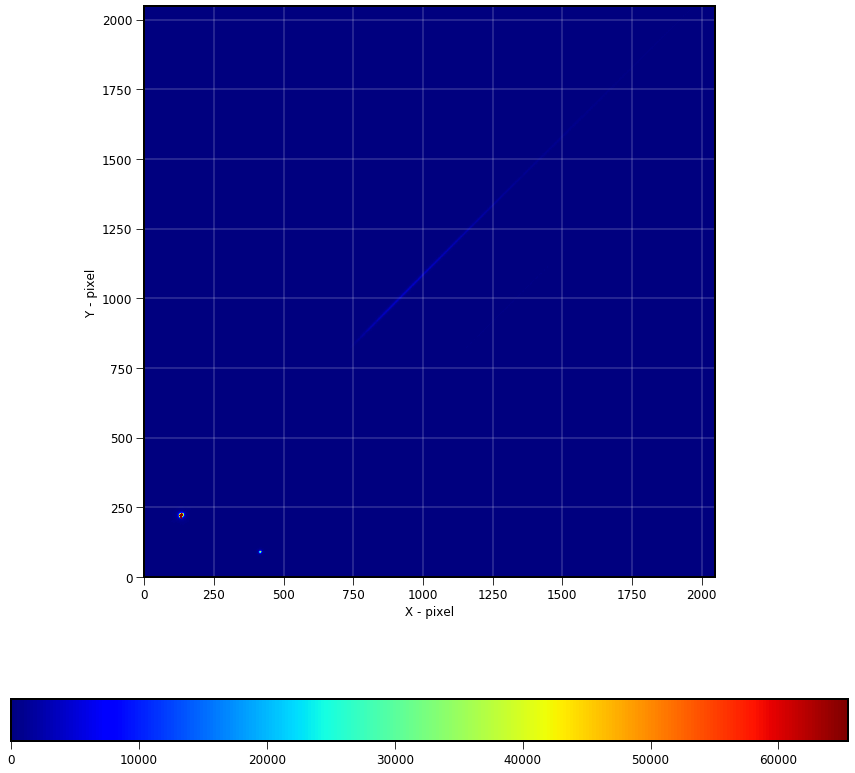

In [41]:
img=plt.imshow(data,origin="lower",cmap="jet")
plt.grid(color="w")
#plt.title(thefilename)
plt.xlabel(" X - pixel ")
plt.ylabel(" Y - pixel ")
plt.colorbar(img,orientation="horizontal")

## Plot histogram

Text(0, 0.5, 'number of pixels')

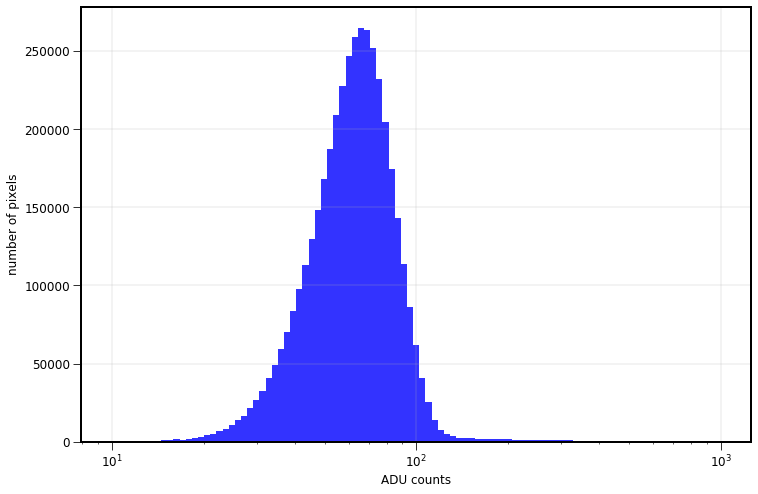

In [42]:
plt.figure(figsize=(12,8))
XMIN=10
XMAX=1000
plt.hist(data.flatten(), bins = 10 ** np.linspace(np.log10(XMIN), np.log10(XMAX), 100),color="b",alpha=0.8)
plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")
plt.grid()
#plt.title("Reduced image ADU counts for {}".format(thefilename))
plt.xlabel("ADU counts")
plt.ylabel("number of pixels")

In [43]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0)    
print((mean, median, std))    

(62.683913040066145, 62.160806867873916, 18.221840820359397)


## Search Sources in raw image

In [44]:
daofind = DAOStarFinder(fwhm=10.0, threshold=10.*std)    
#sources = daofind(data - median) 
sources = daofind(data) 

In [63]:
for col in sources.colnames:    
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)    

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
  1 416.82349 89.841687 0.55505862 ...   0 43083.504 594.84191  -6.9360039
  2 131.36828 220.22083 0.39960252 ...   0 64680.075 545.08733  -6.8411652
  3 135.39845 222.28779 0.32487395 ...   0 65011.027 617.01166  -6.9757334
  4 400.91073 247.45616 0.74895549 ...   0 207.71928 1.3796354 -0.34941084
  5 1968.8042 2043.2368 0.45015744 ...   0 277.49539 3.2343436  -1.2744654


In [70]:
y0=sources["ycentroid"][0]
x0=sources["xcentroid"][0]
width=20
xmin=int(x0-width)
xmax=int(x0+width)
ymin=int(y0-width)
ymax=int(y0+width)



In [71]:
x0

416.8234928917993

In [72]:
vignette=data[ymin:ymax,xmin:xmax]

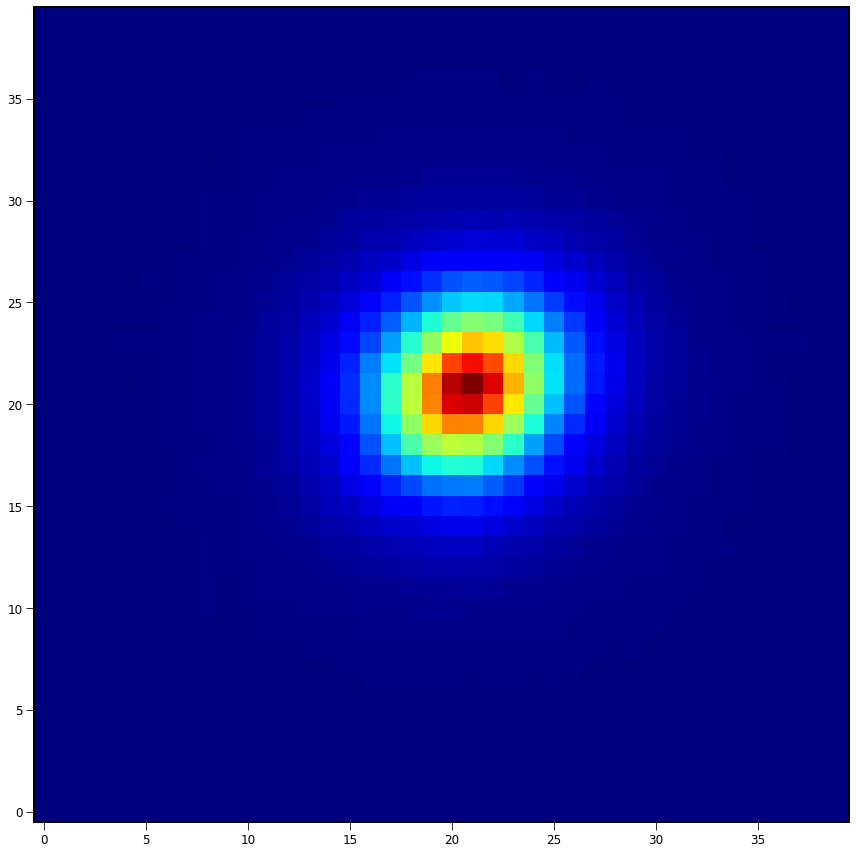

In [74]:
plt.imshow(vignette,origin='lower',cmap="jet")

In [75]:
from photutils import aperture_photometry
from photutils import CircularAperture

In [76]:
apertures = CircularAperture(positions, r=25.)

In [58]:
apertures

<CircularAperture([[ 416.82349289,   89.84168732],
                   [ 131.36828402,  220.22082887],
                   [ 135.39844828,  222.28779494],
                   [ 400.91073446,  247.4561578 ],
                   [1968.80417575, 2043.23682921]], r=20.0)>

In [77]:
phot_table = aperture_photometry(data, apertures)

In [78]:
phot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,416.8234928917993,89.8416873242267,2965318.954739122
2,131.36828402243083,220.22082886576672,19552307.87473757
3,135.39844827885267,222.28779493660574,19558123.91697944
4,400.91073445557066,247.45615780168603,184213.73964130087
5,1968.804175749625,2043.2368292092265,121242.39643387013


In [79]:
assert False

AssertionError: 

Text(0, 0.5, ' Y - pixel ')

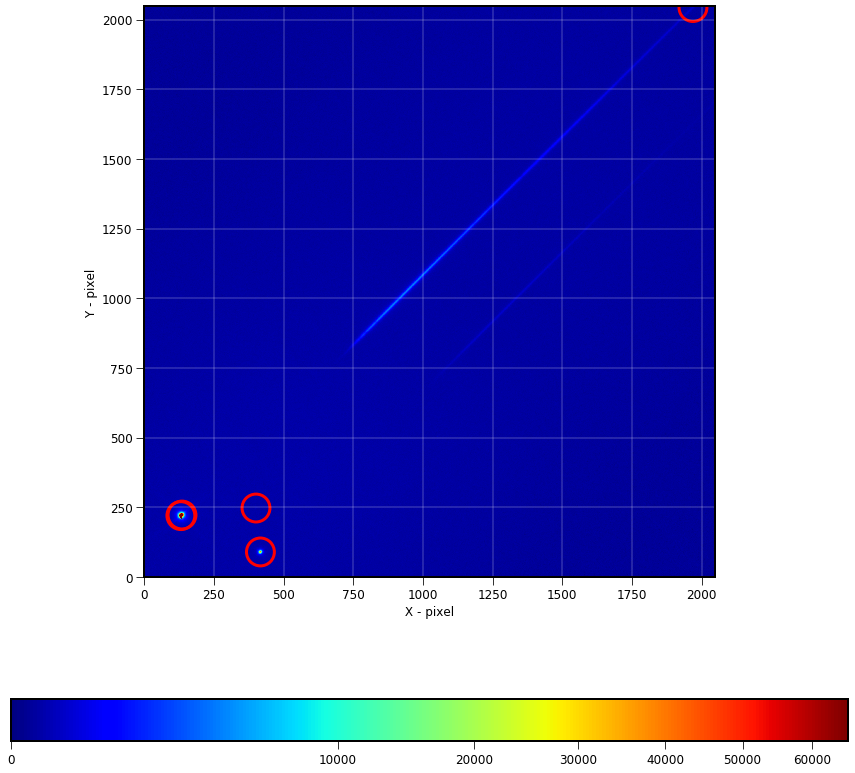

In [47]:
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=50.)
norm = ImageNormalize(stretch=SqrtStretch())
#plt.imshow(data,cmap='Greys', origin='lower', norm=norm)
img=plt.imshow(data,cmap='jet', origin='lower', norm=norm)
apertures.plot(color='red', lw=3, alpha=1.0)

plt.grid(color="w")
#plt.title(thefilename)
plt.colorbar(img,orientation="horizontal")
plt.xlabel(" X - pixel ")
plt.ylabel(" Y - pixel ")

## Background extraction

In [ ]:
mask = make_source_mask(data, snr=3, npixels=5, dilate_size=11)
mean, median, std = sigma_clipped_stats(data, sigma=3.0, mask=mask)
print((mean, median, std))  

In [ ]:
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

In [ ]:
#img=plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
img=plt.imshow(bkg.background, origin='lower', cmap='jet')
plt.grid(color="w")
plt.title("Background for {}".format(thefilename))
plt.xlabel(" X - pixel ")
plt.ylabel(" Y - pixel ")
plt.colorbar(img,orientation="horizontal")

In [ ]:
plt.figure(figsize=(12,8))
XMIN=10
XMAX=1000
plt.hist(bkg.background.flatten(), bins = 10 ** np.linspace(np.log10(XMIN), np.log10(XMAX), 100),color="b",alpha=0.8)
plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")
plt.grid()
plt.title("Background ADU counts for {}".format(thefilename))
plt.xlabel("ADU counts")
plt.ylabel("number of pixels")

In [ ]:
plt.figure(figsize=(12,8))
XMIN=20
XMAX=100
plt.hist(bkg.background.flatten(), bins = np.linspace(XMIN,XMAX, 100),color="b",alpha=0.8)
#plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")
plt.grid()
plt.title("Background ADU counts for {}".format(thefilename))
plt.xlabel("ADU counts")
plt.ylabel("number of pixels")

In [ ]:
signal=data - bkg.background
vmin=signal.min()
vmax=signal.max()/50.
#plt.imshow(signal, norm=norm, origin='lower',cmap='Greys_r',vmin=vmin,vmax=vmax)
img=plt.imshow(signal, norm=norm, origin='lower',cmap='jet',vmin=vmin,vmax=vmax)
plt.colorbar(img,orientation="horizontal")
plt.title("Signal for {}".format(thefilename))
plt.xlabel(" X - pixel ")
plt.ylabel(" Y - pixel ")
plt.grid(color="w")

In [ ]:
mean, median, std = sigma_clipped_stats(signal, sigma=3.0)    
print((mean, median, std))    

In [ ]:
daofind = DAOStarFinder(fwhm=10.0, threshold=100.*std)    
sources = daofind(data - median) 

In [ ]:
for col in sources.colnames:    
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)   

In [ ]:
sources

In [ ]:
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=50.)
norm = ImageNormalize(stretch=SqrtStretch())
#plt.imshow(data,cmap='Greys', origin='lower', norm=norm)
img=plt.imshow(signal,cmap='jet', origin='lower', norm=norm,vmin=vmin,vmax=vmax)
apertures.plot(color='red', lw=3, alpha=1.0)
plt.grid(color="w")
plt.title("Signal for {}".format(thefilename))
plt.colorbar(img,orientation="horizontal")
plt.xlabel(" X - pixel ")
plt.ylabel(" Y - pixel ")

In [ ]:
plt.figure(figsize=(12,8))
XMIN=0.01
XMAX=10000
plt.hist(signal.flatten(), bins = 10 ** np.linspace(np.log10(XMIN), np.log10(XMAX), 100),color="b",alpha=0.8)
plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")
plt.grid()
plt.title("Signal ADU counts for {}".format(thefilename))
plt.xlabel("ADU counts")
plt.ylabel("number of pixels")

In [ ]:
x0=sources["xcentroid"][0]
y0=sources["ycentroid"][0]
siz=20
pixel_to_arcsec=0.159
extent=(-siz*pixel_to_arcsec,siz*pixel_to_arcsec, -siz*pixel_to_arcsec,siz*pixel_to_arcsec )

In [ ]:
vignette=signal[int(y0-siz):int(y0+siz),int(x0-siz):int(x0+siz)]

In [ ]:
plt.figure(figsize=(12,8))
XMIN=10
XMAX=100000
plt.hist(vignette.flatten(), bins = 10 ** np.linspace(np.log10(XMIN), np.log10(XMAX), 100),color="b",alpha=0.8)
plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")
plt.grid()
plt.title("Star ADU counts for {}".format(thefilename))
plt.xlabel("ADU counts")
plt.ylabel("number of pixels")

In [ ]:
img=plt.imshow(vignette,origin="lower",cmap="jet",extent=extent)
plt.colorbar(img,orientation="horizontal")
plt.xlabel("$\\theta_X$ (arcsec)")
plt.ylabel("$\\theta_Y$ (arcsec)")
plt.title(thefilename)
plt.grid(color="white")

In [ ]:
histx=vignette.sum(axis=0)
histy=vignette.sum(axis=1)

In [ ]:
lx=len(histx)
ly=len(histy)
mx,sx=weighted_avg_and_std(np.arange(lx),histx)
my,sy=weighted_avg_and_std(np.arange(ly),histy)
hxmin,hxmax=histx.min(),histx.max()
hymin,hymax=histy.min(),histy.max()
hxaver=(hxmin+hxmax)/2.
hyaver=(hymin+hymax)/2.

In [ ]:
sx,sy

In [ ]:
plt.subplot(221)
plt.plot(histx,'b-o')
plt.plot([mx,mx],[hxmin,hxmax],"r-")
plt.plot([(lx+1.)/2.-2.36/2.*sx, (lx+1)/2.+2.36/2.*sx],[hxaver,hxaver],"g-")
plt.xlabel("x - pixel")
plt.title("$\sigma_x$= {:1.2f} pix = {:1.2f} arcsec".format(sx,sx*pixel_to_arcsec))
plt.grid()
plt.subplot(222)
plt.plot(histy,'b-o')
plt.plot([my,my],[hymin,hymax],"r-")
plt.plot([(ly+1)/2.-2.36/2.*sy, (ly+1)/2.+2.36/2.*sy],[hyaver,hyaver],"g-")
plt.xlabel("y - pixel")
plt.title("$\sigma_y$= {:1.2f} pix = {:1.2f} arcsec".format(sy,sy*pixel_to_arcsec))
plt.grid()
plt.suptitle(thefilename,fontsize=20)